In [1]:
import anndata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import numpy as np
import seaborn as sns
import scipy.sparse as ss
import dask.dataframe as dd
from copy import deepcopy
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, plot_confusion_matrix
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier


In [3]:
tr_dnr = 'h1930004'
tt_dnr = 'h1930002'
impute_downsample = 0.5
impute_fold = 20
celltype_col = 'MajorType'
topn = 100

# load cell & cpg meta

In [5]:
cell_meta = pd.read_pickle('../CellTypeMergingAndSummary/Merging/annot-corrected.pdpkl')
cell_meta['ct_id'] = cell_meta[celltype_col].map(dict(zip(cell_meta[celltype_col].unique(),
                                                      range(len(cell_meta[celltype_col].unique())))))

In [6]:
def filter_cells(cell_meta, celltype_col):
    if celltype_col=='MajorType':
        cell_meta_ftr = cell_meta[~cell_meta[celltype_col].isin(['EC','PC','HIF_Unk2'])]
    return cell_meta_ftr
cell_meta_ftr = filter_cells(cell_meta, celltype_col)

## load cpg feat

In [7]:
feat_import = pd.read_pickle('./common.feat_importance.rfc.pdpkl')
feat_import = feat_import[feat_import.isna().sum(1)==0]

feats = feat_import.rank(ascending=False).mean(1).sort_values().index[:topn]

In [8]:
cpg_meta = pd.read_csv(f'dataset_hierachy/cpg-category.common.csv', index_col=0)

cpg_meta = cpg_meta[cpg_meta['category'].isin(feats)]

cpg_meta = cpg_meta.sort_values('category')
cpg_meta['category_id'] = cpg_meta['category'].map(dict(zip(cpg_meta['category'].unique(),
                                                            range(len(cpg_meta['category'].unique())))))

# load cross donor training and test data

In [9]:
if tr_dnr==tt_dnr:
    
    cvf = 0.25
    tmp_adata = anndata.read_h5ad(f'dataset_hierachy/celltype.MajorType.common.{tr_dnr}.h5ad')
    tmp_df = tmp_adata.obs[[]]
    tmp_df[celltype_col] = cell_meta_ftr[celltype_col]
    tt_sel = tmp_df.groupby(celltype_col,group_keys=False).sample(frac=cvf).index
    
    tr_adata = tmp_adata[~tmp_adata.obs.index.isin(tt_sel)].copy()
    tt_adata = tmp_adata[tmp_adata.obs.index.isin(tt_sel)].copy()

else:
    tr_adata = anndata.read_h5ad(f'dataset_hierachy/celltype.MajorType.common.{tr_dnr}.h5ad')
    tt_adata = anndata.read_h5ad(f'dataset_hierachy/celltype.MajorType.common.{tt_dnr}.h5ad')

In [10]:
tr_adata = tr_adata[:,tr_adata.var['common']]
tr_adata.var = tr_adata.var[[]]
tt_adata = tt_adata[:,tt_adata.var['common']]
tt_adata.var = tt_adata.var[[]]


/data/wtian/local/miniconda3/envs/sapiens/lib/python3.8/site-packages/anndata/_core/anndata.py:882: FutureWarning: X.dtype being converted to np.float32 from int8. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._set_dim_df(value, "var")


In [11]:
tr_adata = tr_adata[cell_meta_ftr.index[cell_meta_ftr.index.isin(tr_adata.obs_names)]][:,cpg_meta.index]
tt_adata = tt_adata[cell_meta_ftr.index[cell_meta_ftr.index.isin(tt_adata.obs_names)]][:,cpg_meta.index]

tr_adata.obs[celltype_col] = cell_meta_ftr[celltype_col]
tt_adata.obs[celltype_col] = cell_meta_ftr[celltype_col]
tr_adata.obs[f'{celltype_col}_id'] = cell_meta_ftr['ct_id']
tt_adata.obs[f'{celltype_col}_id'] = cell_meta_ftr['ct_id']

tr_adata.var['category'] = cpg_meta['category']
tt_adata.var['category'] = cpg_meta['category']
tr_adata.var['category_id'] = cpg_meta['category_id']
tt_adata.var['category_id'] = cpg_meta['category_id']

/gale/netapp/home/wtian/sapiens/systmp/ipykernel_74416/383702218.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tr_adata.obs[celltype_col] = cell_meta_ftr[celltype_col]
/gale/netapp/home/wtian/sapiens/systmp/ipykernel_74416/383702218.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tt_adata.obs[celltype_col] = cell_meta_ftr[celltype_col]


In [12]:
tr_adata, tt_adata

(AnnData object with n_obs × n_vars = 11109 × 141237
     obs: 'MajorType', 'MajorType_id'
     var: 'category', 'category_id',
 AnnData object with n_obs × n_vars = 10968 × 141237
     obs: 'MajorType', 'MajorType_id'
     var: 'category', 'category_id')

## get data matrix 

In [13]:
def get_methlv_df(data, kind='cellxcate', downsample=None, cov_only=False, single_site=False, random_state=None):
    x = data.X.tocoo()
    tmpdf = pd.DataFrame()
#     tmpdf['row'] = x.row
    tmpdf['row'] = data.obs_names[x.row]
    tmpdf['col'] = x.col
    tmpdf['val'] = x.data

    
    tmpdf['col_cate'] = tmpdf['col'].map( dict(zip(data.var.reset_index().index, 
                                                   data.var['category'])) )
    tmpdf['row_cate'] = tmpdf['row'].map( dict(zip(data.obs_names, 
                                                   data.obs[f'{celltype_col}'])) )    

    tmpdf['mc'] = tmpdf['val']==1
    tmpdf['cov'] = tmpdf['val']!=0
    
    if not downsample is None:
        assert downsample>0 and downsample<1
        tmpdf = tmpdf.sample(frac=downsample, random_state=random_state)


    def _get_methlv_df(df, row, col, cov_only=False, single_site=False, random_state=None):
        if single_site:
            print('single_site')
            rtn = df[[row,col,'mc','cov']].groupby([row,col], sort=False, group_key=False).sample(1, random_state=random_state)
        rtn = df[[row,col,'mc','cov']].groupby([row,col], sort=False).sum()
        if cov_only:
            rtn = rtn['cov'].to_frame().reset_index()
        else:
            rtn = (rtn['mc']/rtn['cov']).to_frame().reset_index()
        rtn.columns=['row','col','val']
        rtn = rtn.pivot('row','col','val')
        return rtn
    

    if kind=='cellxcate':
        mtx = _get_methlv_df(tmpdf, 'row', 'col_cate',cov_only, single_site, random_state)
    elif kind=='ctxcpg':
        mtx = _get_methlv_df(tmpdf, 'row_cate', 'col', cov_only, single_site, random_state)
    elif kind=='ctxcate':
        mtx = _get_methlv_df(tmpdf, 'row_cate', 'col_cate', cov_only, single_site, random_state)
    else:
        raise NotImplementedError
        

#     # ctxcate = _get_methlv_df(tmpdf, 'row_cate', 'col_cate',cov_only, single_site, random_state)
#     cellxcate.columns = cellxcate.columns.map(dict(zip(data.var['category_id'], data.var['category'], )))
#     cellxcate.index = data.obs_names[cellxcate.index]
    return mtx


In [14]:
tr_cellxcate = get_methlv_df(tr_adata)
tt_cellxcate = get_methlv_df(tt_adata)

In [15]:
### cellxcate matrix may not have the same columns due to the sparsity

comm_cols = tt_cellxcate.columns.intersection(tr_cellxcate.columns)
tr_cellxcate = tr_cellxcate[comm_cols]
tt_cellxcate = tt_cellxcate[comm_cols]


## build imputer

In [16]:
forknn = []
for i in range(impute_fold):
    ctxcate = get_methlv_df(tr_adata, kind='ctxcate', downsample=impute_downsample, random_state=i)
    forknn.append(ctxcate)
forknn = pd.concat(forknn)[comm_cols]

In [17]:
knn_imputer = KNNImputer()
knn_imputer.fit(forknn)

KNNImputer()

In [18]:
tr_ip_cellxcate = knn_imputer.transform(tr_cellxcate)
tr_ip_cellxcate = pd.DataFrame(tr_ip_cellxcate, index=tr_cellxcate.index, columns=tr_cellxcate.columns)
tt_ip_cellxcate = knn_imputer.transform(tt_cellxcate)
tt_ip_cellxcate = pd.DataFrame(tt_ip_cellxcate, index=tt_cellxcate.index, columns=tt_cellxcate.columns)


## binnarize data matrix

In [19]:
def binnarize(df):
    return (df<0.5)*(-1)+(df>0.5)*(1)

In [20]:
tr_cellxcate_bin = binnarize(tr_cellxcate)
tt_cellxcate_bin = binnarize(tt_cellxcate)

tr_ip_cellxcate_bin = binnarize(tr_ip_cellxcate)
tt_ip_cellxcate_bin = binnarize(tt_ip_cellxcate)

In [21]:
tr_y = cell_meta_ftr.loc[tr_cellxcate.index][celltype_col]
tt_y = cell_meta_ftr.loc[tt_cellxcate.index][celltype_col]

# training and testing

In [22]:
rfc = RandomForestClassifier()
rfc_ip = RandomForestClassifier()

In [23]:
rfc.fit(tr_cellxcate_bin, tr_y)
rfc_ip.fit(tr_ip_cellxcate_bin, tr_y)

RandomForestClassifier()

In [24]:
accuracy_score(rfc.predict(tt_cellxcate_bin),tt_y)

0.8321480671043034

/data/wtian/local/miniconda3/envs/sapiens/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


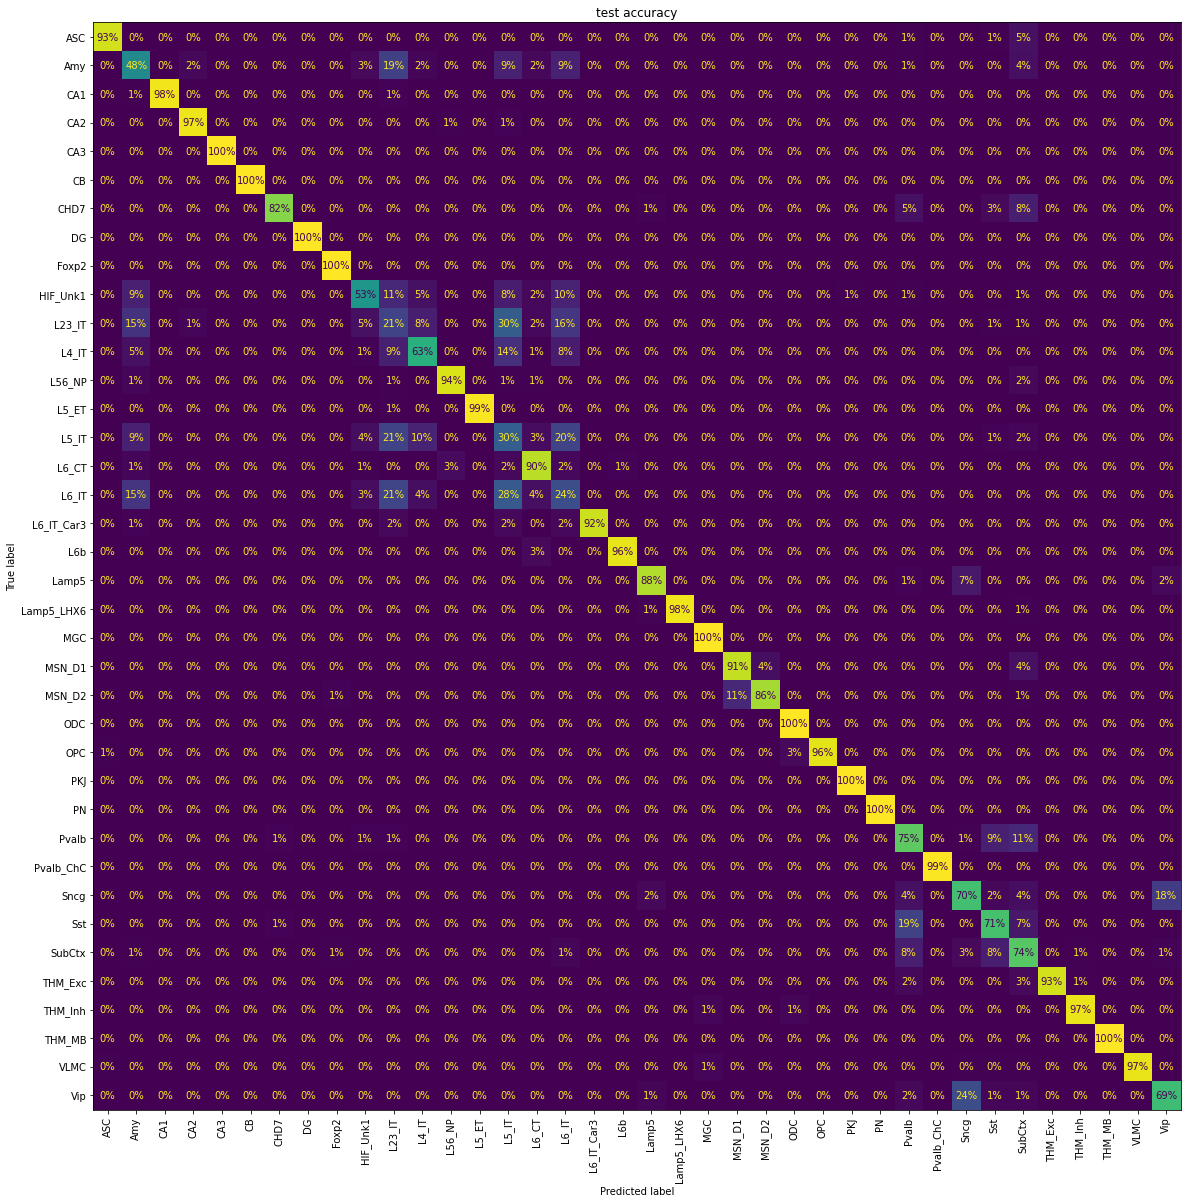

In [25]:
plt.figure(figsize=(20,20))
plot_confusion_matrix(rfc, tt_cellxcate_bin, tt_y,
                      normalize='true',values_format='.0%',
                      colorbar=False,
                      ax=plt.gca())
plt.xticks(rotation = 90)
plt.title('test accuracy')
plt.show()

In [26]:
accuracy_score(rfc_ip.predict(tt_ip_cellxcate_bin),tt_y)

0.8282275711159738

/data/wtian/local/miniconda3/envs/sapiens/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


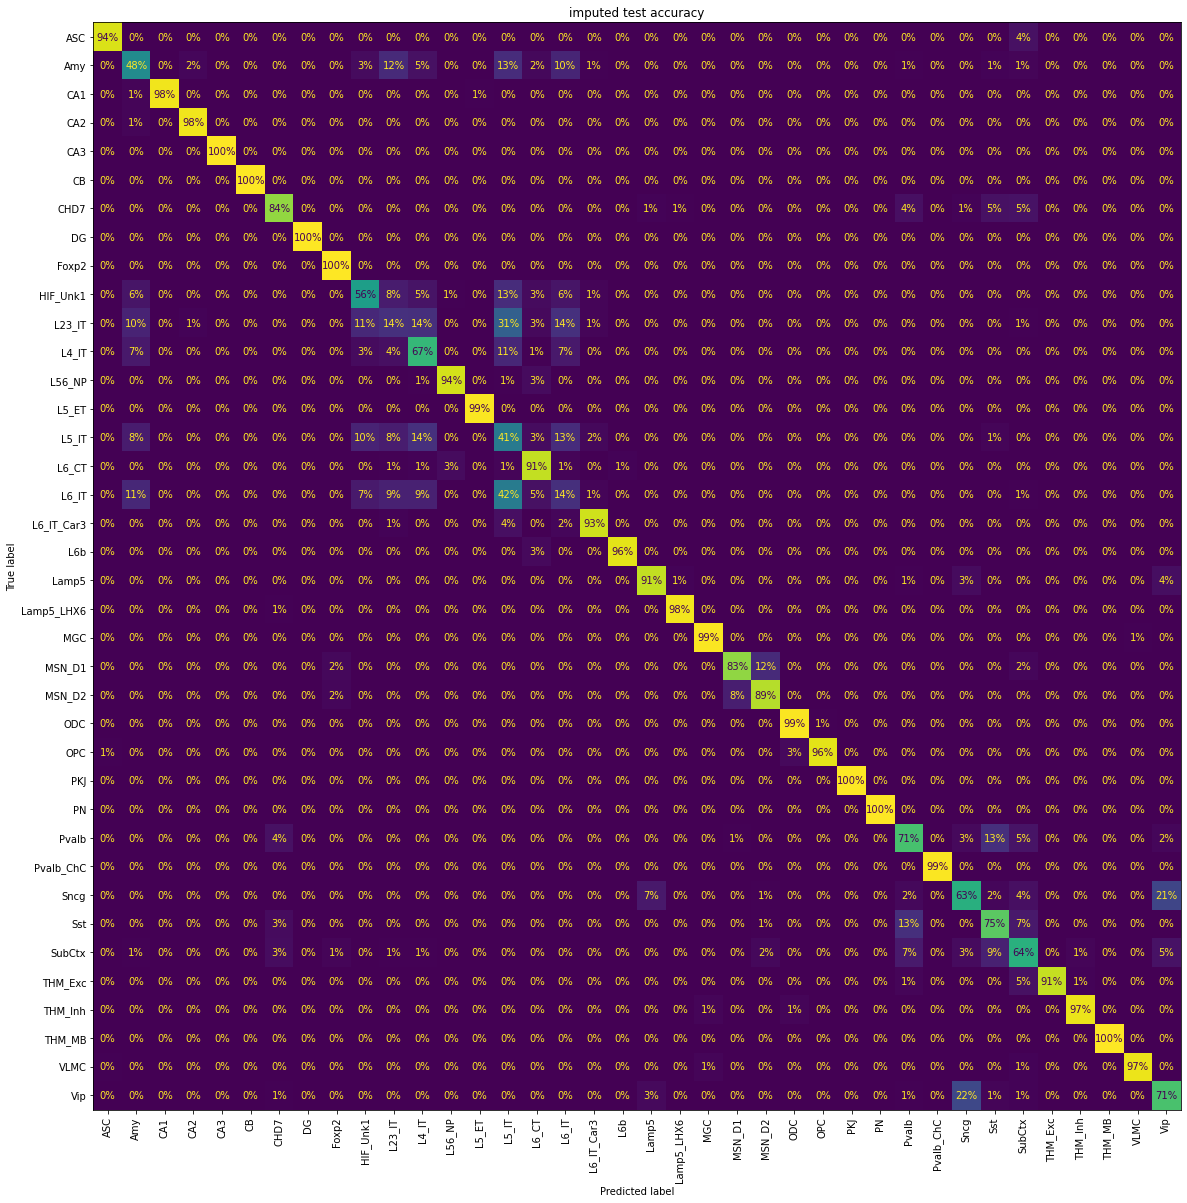

In [27]:
plt.figure(figsize=(20,20))
plot_confusion_matrix(rfc_ip, tt_ip_cellxcate_bin, tt_y,
                      normalize='true',values_format='.0%',
                      colorbar=False,
                      ax=plt.gca())
plt.xticks(rotation = 90)
plt.title('imputed test accuracy')
plt.show()

# save

In [28]:
from pathlib import Path
import joblib

In [29]:
impute_downsample_str = str(int(impute_downsample*100)).zfill(3)
impute_fold_str = str(impute_fold).zfill(3)

In [30]:
outdir = f'common.feat_{topn}.tr_{tr_dnr}.tt_{tt_dnr}.impdown_{impute_downsample_str}'\
        f'.impfold_{impute_fold_str}.ct_{celltype_col}'
outdir = Path('results/'+outdir)
outdir.mkdir(exist_ok=True)

In [31]:
joblib.dump(knn_imputer,outdir/'knn_imputer.joblib')
joblib.dump(rfc,outdir/'rfc.joblib')
joblib.dump(rfc_ip,outdir/'rfc_ip.joblib')
tr_cellxcate.to_pickle(outdir/'tr_cellxcate.pdpkl')
tt_cellxcate.to_pickle(outdir/'tt_cellxcate.pdpkl')
tr_ip_cellxcate.to_pickle(outdir/'tr_ip_cellxcate.pdpkl')
tt_ip_cellxcate.to_pickle(outdir/'tt_ip_cellxcate.pdpkl')


In [32]:
# for tr_dnr in ['h1930001','h1930002','h1930004']:
#     for tt_dnr in ['h1930001','h1930002','h1930004']:        
#         for cpg_dnr in ['h1930001','h1930002','h1930004']:    
#             print(f'papermill -p tr_dnr {tr_dnr} -p tt_dnr {tt_dnr} -p cpg_dnr {cpg_dnr} '
#             f'barcode-prediction-separated-template.ipynb results/tmp_{tr_dnr}_{tt_dnr}_{cpg_dnr}.ipynb')